In [7]:
import tensorflow as tf


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
import numpy as np
import os
from PIL import Image
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

# extract features from each photo in the directory
def extract_features(directory):
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # summarize
    print(model.summary())
    # extract features from each photo
    features = {}
    for name in os.listdir(directory):
        # load an image from file
        filename = os.path.join(directory, name)
        image = Image.open(filename)
        # resize image to (224, 224)
        image = image.resize((224, 224))
        # convert PIL image to numpy array
        image = np.array(image)
        # reshape data for the model
        image = np.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model
        image = preprocess_input(image)
        # get features
        feature = model.predict(image, verbose=0)
        # get image id
        image_id = name.split('.')[0]
        # store feature
        features[image_id] = feature
        print('>%s' % name)
    return features

# extract features from all images
directory = '/kaggle/input/flickr8k-dataset/Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features.pkl', 'wb'))


In [9]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
# import string

# # load doc into memory
# def load_doc(filename):
# 	# open the file as read only
# 	file = open(filename, 'r')
# 	# read all text
# 	text = file.read()
# 	# close the file
# 	file.close()
# 	return text

# # extract descriptions for images
# def load_descriptions(doc):
# 	mapping = dict()
# 	# process lines
# 	for line in doc.split('\n'):
# 		# split line by white space
# 		tokens = line.split()
# 		if len(line) < 2:
# 			continue
# 		# take the first token as the image id, the rest as the description
# 		image_id, image_desc = tokens[0], tokens[1:]
# 		# remove filename from image id
# 		image_id = image_id.split('.')[0]
# 		# convert description tokens back to string
# 		image_desc = ' '.join(image_desc)
# 		# create the list if needed
# 		if image_id not in mapping:
# 			mapping[image_id] = list()
# 		# store description
# 		mapping[image_id].append(image_desc)
# 	return mapping

# def clean_descriptions(descriptions):
# 	# prepare translation table for removing punctuation
# 	table = str.maketrans('', '', string.punctuation)
# 	for key, desc_list in descriptions.items():
# 		for i in range(len(desc_list)):
# 			desc = desc_list[i]
# 			# tokenize
# 			desc = desc.split()
# 			# convert to lower case
# 			desc = [word.lower() for word in desc]
# 			# remove punctuation from each token
# 			desc = [w.translate(table) for w in desc]
# 			# remove hanging 's' and 'a'
# 			desc = [word for word in desc if len(word)>1]
# 			# remove tokens with numbers in them
# 			desc = [word for word in desc if word.isalpha()]
# 			# store as string
# 			desc_list[i] =  ' '.join(desc)

# # convert the loaded descriptions into a vocabulary of words
# def to_vocabulary(descriptions):
# 	# build a list of all description strings
# 	all_desc = set()
# 	for key in descriptions.keys():
# 		[all_desc.update(d.split()) for d in descriptions[key]]
# 	return all_desc

# # save descriptions to file, one per line
# def save_descriptions(descriptions, filename):
# 	lines = list()
# 	for key, desc_list in descriptions.items():
# 		for desc in desc_list:
# 			lines.append(key + ' ' + desc)
# 	data = '\n'.join(lines)
# 	file = open(filename, 'w')
# 	file.write(data)
# 	file.close()

# filename = '/kaggle/input/flickr8k-text/Flickr8k.token.txt'
# # load descriptions
# doc = load_doc(filename)
# # parse descriptions
# descriptions = load_descriptions(doc)
# print('Loaded: %d ' % len(descriptions))
# # clean descriptions
# clean_descriptions(descriptions)
# # summarize vocabulary
# vocabulary = to_vocabulary(descriptions)
# print('Vocabulary Size: %d' % len(vocabulary))
# # save to file
# save_descriptions(descriptions, 'descriptions.txt')

Loaded: 8092 
Vocabulary Size: 8763


In [11]:
clean_descriptions(descriptions)

In [21]:
from pickle import load

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

# load training dataset (6K)
filename = '/kaggle/input/flickr8k-text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('/kaggle/input/output/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('/kaggle/input/output/features.pkl', train)
print('Photos: train=%d' % len(train_features))

Dataset: 6000
Descriptions: train=6000
Photos: train=6000


In [22]:
from keras.preprocessing.text import Tokenizer

# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 7579


In [23]:
# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [24]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
	X1, X2, y = list(), list(), list()
	# walk through each description for the image
	for desc in desc_list:
		# encode the sequence
		seq = tokenizer.texts_to_sequences([desc])[0]
		# split one sequence into multiple X,y pairs
		for i in range(1, len(seq)):
			# split into input and output pair
			in_seq, out_seq = seq[:i], seq[i]
			# pad input sequence
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			# encode output sequence
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			# store
			X1.append(photo)
			X2.append(in_seq)
			y.append(out_seq)
	return array(X1), array(X2), array(y)

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [26]:
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add


from keras.callbacks import ModelCheckpoint

In [27]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
	# loop for ever over images
	while 1:
		for key, desc_list in descriptions.items():
			# retrieve the photo feature
			photo = photos[key][0]
			in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
			yield [in_img, in_seq], out_word

In [19]:
# prepare sequences
# X1train, X2train, ytrain = create_sequences(tokenizer,max_length, train_descriptions, train_features, vocab_size)

In [20]:
# print(X1train)
# # print(X2train)
# # print(ytrain)

[[1.9046047  0.         0.         ... 0.         0.         0.        ]
 [1.9046047  0.         0.         ... 0.         0.         0.        ]
 [1.9046047  0.         0.         ... 0.         0.         0.        ]
 ...
 [0.93764466 0.73593855 0.         ... 0.         1.8502848  0.        ]
 [0.93764466 0.73593855 0.         ... 0.         1.8502848  0.        ]
 [0.93764466 0.73593855 0.         ... 0.         1.8502848  0.        ]]


In [21]:
# # print(X1train)
# print(X2train)
# # print(ytrain)

[[   0    0    0 ...    0    0    1]
 [   0    0    0 ...    0    1   42]
 [   0    0    0 ...    1   42    3]
 ...
 [   0    0    0 ...  352    9  567]
 [   0    0    0 ...    9  567 1040]
 [   0    0    0 ...  567 1040 1731]]


In [67]:
# # print(X1train)
# # print(X2train)
# print(ytrain)

In [28]:
# define the captioning model
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
	print(model.summary())
	plot_model(model, to_file='model.png', show_shapes=True)
	return model

In [11]:
# define the model
model = define_model(vocab_size, max_length)
# train the model, run epochs manually and save after each epoch
epochs = 9
steps = len(train_descriptions)
for i in range(epochs):
	# create the data generator
	generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
	# fit for one epoch
	model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
	# save model
	model.save('model_' + str(i) + '.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 256)      1940224     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_1[0][0]']                
                                                                                              

/tmp/ipykernel_32/740774018.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


6000/6000 [==============================] - 724s 121ms/step - loss: 3.1787


In [29]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

In [14]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [16]:
# load test set
filename = '/kaggle/input/flickr8k-text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('/kaggle/input/output/descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('/kaggle/input/output/features.pkl', test)
print('Photos: test=%d' % len(test_features))

Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [34]:

from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

In [65]:
filename = '/kaggle/working/model_8.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.503172
BLEU-2: 0.245901
BLEU-3: 0.170017
BLEU-4: 0.078626


In [30]:

from keras.preprocessing.text import Tokenizer
from pickle import dump

In [31]:
filename = '/kaggle/input/flickr8k-text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('/kaggle/input/output/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

Dataset: 6000
Descriptions: train=6000


In [32]:
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34

In [35]:
# load the model
model = load_model('/kaggle/input/models-files/model_8.h5')

In [36]:
import numpy as np
# from keras.preprocessing.image import preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from PIL import Image


In [37]:
from PIL import Image

def extract_features(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = Image.open(filename)
    # resize the image
    image = image.resize((224, 224))
    # convert the image pixels to a numpy array
    image = np.array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature


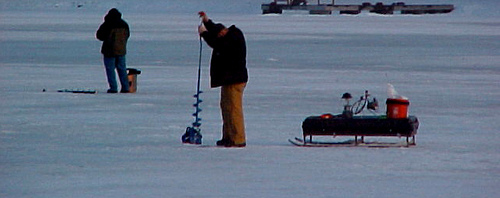

startseq man in red shirt is riding on the beach endseq


In [40]:
photo = extract_features('/kaggle/input/flickr8k-dataset/Flicker8k_Dataset/102351840_323e3de834.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)



from PIL import Image
from IPython.display import display

# specify the path to your image
image_path = '/kaggle/input/flickr8k-dataset/Flicker8k_Dataset/102351840_323e3de834.jpg'

# open the image using Pillow
image = Image.open(image_path)

# display the image in the notebook
display(image)
print(description)

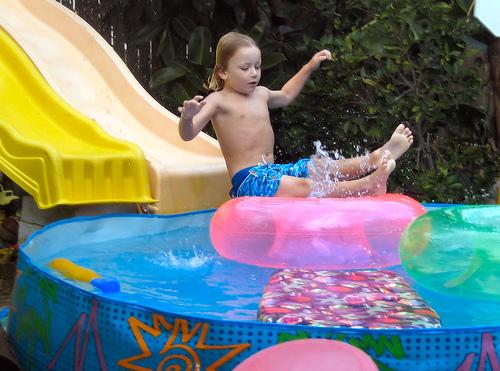

startseq young boy in blue shirt is playing in the water endseq


In [47]:
photo = extract_features('/kaggle/input/flickr8k-dataset/Flicker8k_Dataset/1077546505_a4f6c4daa9.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)



from PIL import Image
from IPython.display import display

# specify the path to your image
image_path = '/kaggle/input/flickr8k-dataset/Flicker8k_Dataset/1077546505_a4f6c4daa9.jpg'

# open the image using Pillow
image = Image.open(image_path)

# display the image in the notebook
display(image)
print(description)

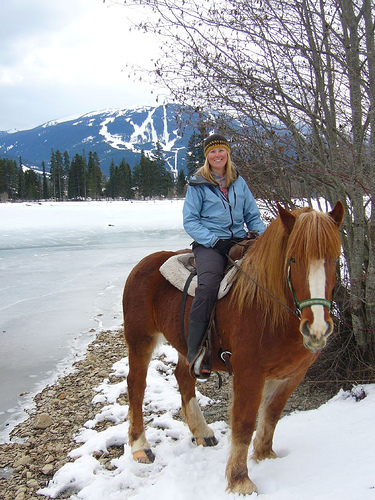

startseq horse is running through the snow endseq


In [54]:
photo = extract_features('/kaggle/input/flickr8k-dataset/Flicker8k_Dataset/109202756_b97fcdc62c.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)



from PIL import Image
from IPython.display import display

# specify the path to your image
image_path = '/kaggle/input/flickr8k-dataset/Flicker8k_Dataset/109202756_b97fcdc62c.jpg'

# open the image using Pillow
image = Image.open(image_path)

# display the image in the notebook
display(image)
print(description)

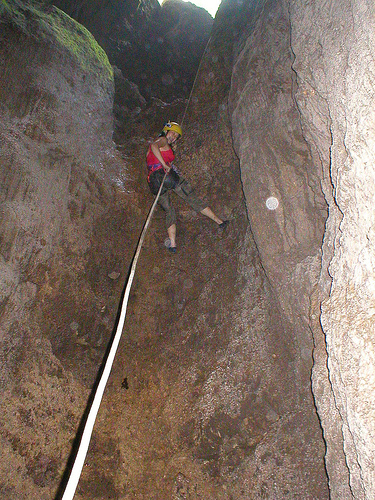

startseq man in red shirt is standing on rock endseq


In [53]:
photo = extract_features('/kaggle/input/flickr8k-dataset/Flicker8k_Dataset/109260216_85b0be5378.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)



from PIL import Image
from IPython.display import display

# specify the path to your image
image_path = '/kaggle/input/flickr8k-dataset/Flicker8k_Dataset/109260216_85b0be5378.jpg'

# open the image using Pillow
image = Image.open(image_path)

# display the image in the notebook
display(image)
print(description)

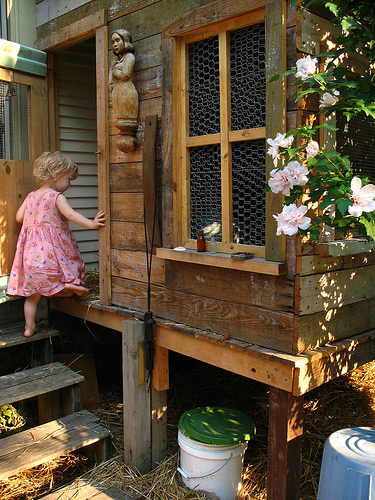

startseq man in black shirt is standing on the street with her arms outstretched endseq


In [51]:
photo = extract_features('/kaggle/input/flickr8k-dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)



from PIL import Image
from IPython.display import display

# specify the path to your image
image_path = '/kaggle/input/flickr8k-dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg'

# open the image using Pillow
image = Image.open(image_path)

# display the image in the notebook
display(image)
print(description)

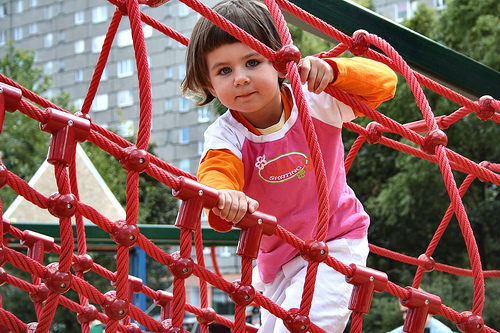

startseq girl is playing in the grass endseq


In [58]:
photo = extract_features('/kaggle/input/flickr8k-dataset/Flicker8k_Dataset/1007320043_627395c3d8.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)



from PIL import Image
from IPython.display import display

# specify the path to your image
image_path = '/kaggle/input/flickr8k-dataset/Flicker8k_Dataset/1007320043_627395c3d8.jpg'

# open the image using Pillow
image = Image.open(image_path)

# display the image in the notebook
display(image)
print(description)

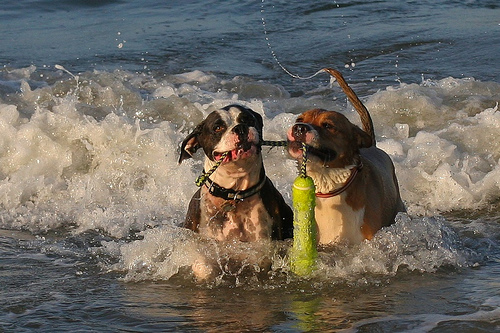

startseq dog is running through the water endseq


In [59]:
photo = extract_features('/kaggle/input/flickr8k-dataset/Flicker8k_Dataset/1129704496_4a61441f2c.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)



from PIL import Image
from IPython.display import display

# specify the path to your image
image_path = '/kaggle/input/flickr8k-dataset/Flicker8k_Dataset/1129704496_4a61441f2c.jpg'

# open the image using Pillow
image = Image.open(image_path)

# display the image in the notebook
display(image)
print(description)

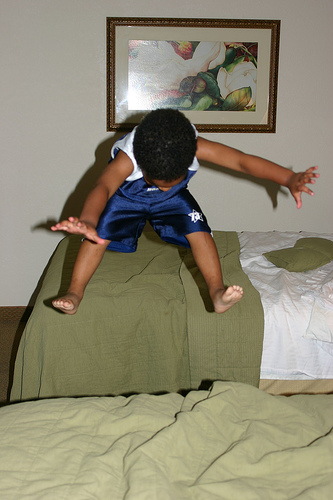

startseq two girls are playing on trampoline endseq


In [61]:
photo = extract_features('/kaggle/input/flickr8k-dataset/Flicker8k_Dataset/1131932671_c8d17751b3.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)



from PIL import Image
from IPython.display import display

# specify the path to your image
image_path = '/kaggle/input/flickr8k-dataset/Flicker8k_Dataset/1131932671_c8d17751b3.jpg'

# open the image using Pillow
image = Image.open(image_path)

# display the image in the notebook
display(image)
print(description)

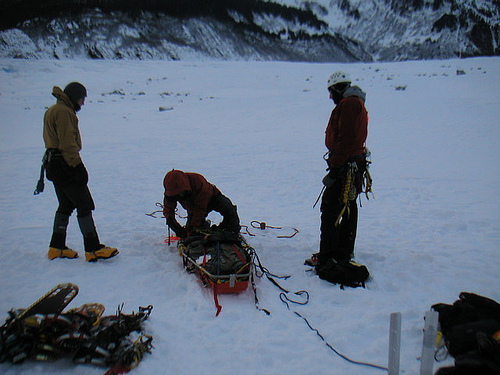

startseq two people are standing on mountain overlooking the mountains endseq


In [62]:
photo = extract_features('/kaggle/input/flickr8k-dataset/Flicker8k_Dataset/115684808_cb01227802.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)



from PIL import Image
from IPython.display import display

# specify the path to your image
image_path = '/kaggle/input/flickr8k-dataset/Flicker8k_Dataset/115684808_cb01227802.jpg'

# open the image using Pillow
image = Image.open(image_path)

# display the image in the notebook
display(image)
print(description)

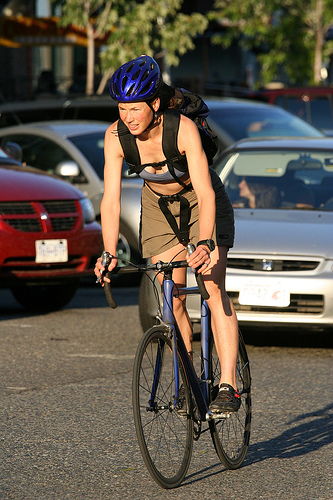

startseq man in red shirt and helmet riding bike on the road endseq


In [64]:
photo = extract_features('/kaggle/input/flickr8k-dataset/Flicker8k_Dataset/1142847777_2a0c1c2551.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)



from PIL import Image
from IPython.display import display

# specify the path to your image
image_path = '/kaggle/input/flickr8k-dataset/Flicker8k_Dataset/1142847777_2a0c1c2551.jpg'

# open the image using Pillow
image = Image.open(image_path)

# display the image in the notebook
display(image)
print(description)